# Modeling Usage Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from vtt.utils.helpers import set_seed
from vtt.data.caption_preprocessing import load_tokenizer
from vtt.data.image_preprocessing import load_features
from vtt.data.data_loader import load_training_dataset
from vtt.models.decoder import build_decoder_model
from vtt.models.train import train_model
from vtt.models.predict import display_images_with_captions

2025-07-15 12:00:15.650378: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 12:00:15.712245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752595215.742326  210310 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752595215.750898  210310 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752595215.786742  210310 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Set Random Seed

In [3]:
set_seed(42)

Random seed set to 42


## Load Processed Data

In [4]:
dataset_name = "flickr8k"
features_path = f"../data/processed/{dataset_name}_features.npz"
captions_path = f"../data/processed/{dataset_name}_padded_caption_sequences.npz"
tokenizer_path = f"../data/processed/{dataset_name}_tokenizer.pkl"

features_npz = np.load(features_path)
captions_npz = np.load(captions_path, allow_pickle=True)
tokenizer = load_tokenizer(tokenizer_path)

# Load training dataset
training_dataset = load_training_dataset(
    features_path=features_path,
    captions_path=captions_path,
    batch_size=64,
    shuffle=True
)

[INFO] Tokenizer loaded from pickle file: ../data/processed/flickr8k_tokenizer.pkl


2025-07-15 12:01:04.118192: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Build Model

In [5]:
# Get max caption length from dataset
for (_, caption_input), _ in training_dataset.take(1):
    max_caption_len = caption_input.shape[1]

# Get vocab size from tokenizer
vocab_size = tokenizer.num_words

model = build_decoder_model(vocab_size=vocab_size, max_caption_len=max_caption_len)
model.summary()

2025-07-15 12:01:08.336741: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "ImageCaptionDecoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense (Dense) │ (None, 256)       │    524,544 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_image        │ (None, 1, 256)    │          0 │ image_dense[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_embedding   │ (None, 18, 256)   │  2,560,000 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_image_caption │ (None, 19, 256)   │          0 │ expand_image[0][… │
│ (Concatenate)       │                   │            │ caption_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 19, 512)   │  1,574,912 │ merge_image_capt… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 19, 10000) │  5,130,000 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trim_image_output   │ (None, 18, 10000) │          0 │ output_dense[0][… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,789,456 (37.34 MB)

 Trainable params: 9,789,456 (37.34 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [6]:
# # Force model to build by running dummy input
# # This forces the model (and all layers inside) to initialize weights before model.fit() 
# # is traced in the tf graph, preventing errors
# dummy_image = tf.random.normal((1, 2048))
# dummy_caption = tf.random.uniform((1, max_caption_len), minval=1, maxval=vocab_size, dtype=tf.int32)
# _ = model((dummy_image, dummy_caption))

# Train model
history = train_model(
    dataset=training_dataset,
    model=model,
    epochs=5,
    checkpoint_path="../models/flickr8k_decoder_weights.weights.h5"
)

Epoch 1/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - loss: 3.5086
Epoch 1: loss improved from inf to 2.83360, saving model to ../models/flickr8k_decoder_weights.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 297s 498ms/step - loss: 3.5075
Epoch 2/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - loss: 2.2093
Epoch 2: loss improved from 2.83360 to 2.15022, saving model to ../models/flickr8k_decoder_weights.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 298s 502ms/step - loss: 2.2092
Epoch 3/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 2.0175
Epoch 3: loss improved from 2.15022 to 1.98082, saving model to ../models/flickr8k_decoder_weights.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 289s 487ms/step - loss: 2.0175
Epoch 4/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.9051
Epoch 4: loss improved from 1.98082 to 1.87328, saving model to ../models/flickr8k_decoder_weights.weights.h5
593/593 ━━━━━━━━━━━━━━━━━━━━ 1340s 2s/step - loss: 1.9050
Epoch 5/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - lo

## Predict Sample Captions

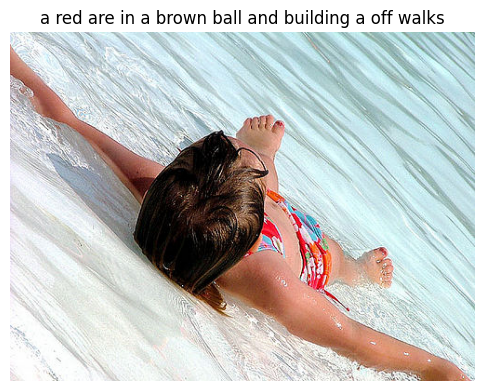

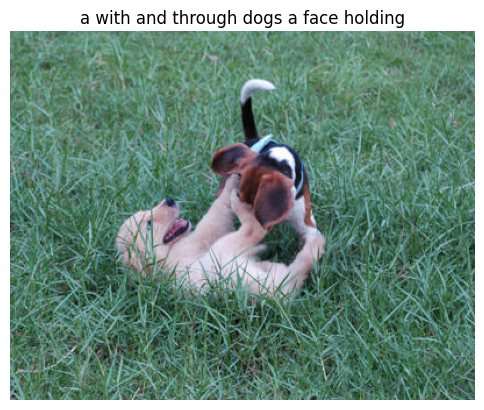

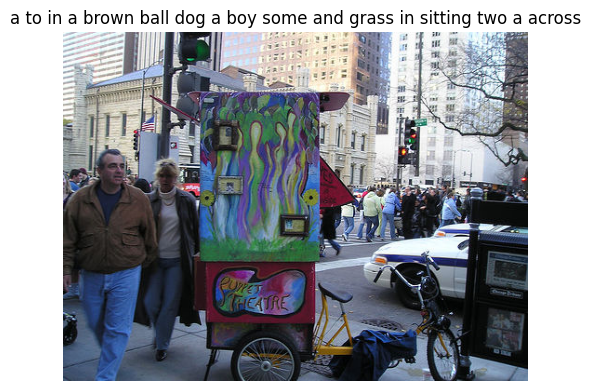

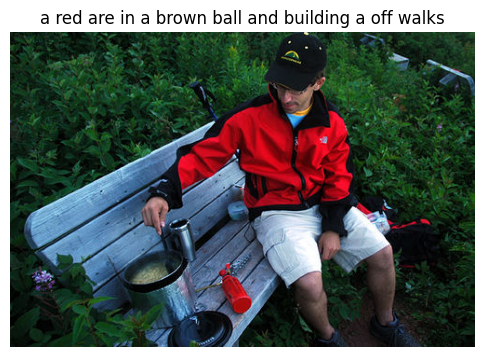

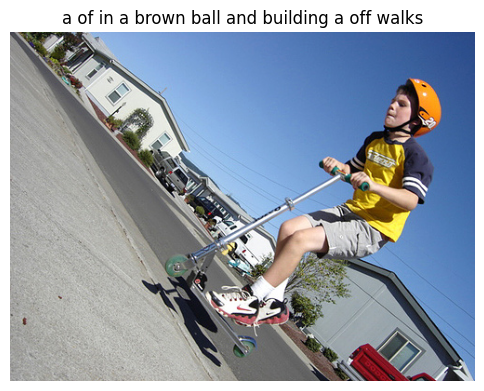

In [7]:
# Update this path to your local copy of the images
image_folder = f"../../data/flickr8k_images/subset"

# Define sample image ids
sample_image_ids = [ 
    "667626_18933d713e.jpg", 
    "23445819_3a458716c1.jpg", 
    "27782020_4dab210360.jpg",
    "35506150_cbdb630f4f.jpg", 
    "47870024_73a4481f7d.jpg"
]

display_images_with_captions(
    image_ids=sample_image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features_npz,
    image_folder=image_folder
)